# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Import Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


# Loading the Data

The dataset is available in two forms

1. .csv file
2. SQLite Database
I have to used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.

In [2]:
connection = sqlite3.connect('database.sqlite')

# filtering only positive and negative reviews . 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", connection) 

# partition reviews to positive and Negative data

def partition(x):
    if x < 3:
        return 'Negative'
    return 'Positive'

#changing reviews with score less than 3 to be negative and score greater than 3 will be positive

Score = filtered_data['Score']
positiveNegative = Score.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head()


Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Check For Duplicate

In [3]:
# First i will sort the data by ProductId

sort_data = filtered_data.sort_values('ProductId', axis=0, ascending=False, kind='quicksort', na_position='last')

# Drop Duplicate 

data = sort_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False) #keep the first and remove the rest
data.shape

(46072, 10)

In [4]:
data['Score'].value_counts()

Positive    38480
Negative     7592
Name: Score, dtype: int64

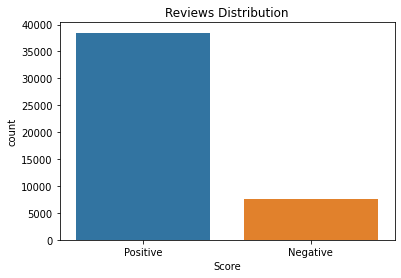

In [5]:
sns.countplot(x='Score', data=data)
plt.title('Reviews Distribution')
plt.show()

# Preprocessing Review Text

1. Begin by removing the html tags or URL
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

In [6]:
# printing some random reviews
sent_0 = data['Text'].values[2]
print(sent_0)
print("="*50)

sent_1000 = data['Text'].values[1060]
print(sent_1000)
print("="*50)

sent_1500 = data['Text'].values[1900]
print(sent_1500)
print("="*50)

sent_4900 = data['Text'].values[4955]
print(sent_4900)
print("="*50)

This Trader Joe's product is good quality.  But buy it straight from TJ's.  This retailer selling this product for twice the price that TJ's sells it for is reprehensible.  Shame on you!
This is my flavor, actually, this is the only flavor I've liked aside from the natural.  Obviously, 1/2 the folks here hated it, half loved it,  I'd recommend trying a variety pack or buying a single before commiting to a large volume purchase.  But hey, if you buy it and don't like it, feel free to send it my way.
Since people can't seem to figure out that the reviews are for the products and not the companies delivering them, I've decided to write a review exclusively FOR THIS PRODUCT.<br /><br />Despite it's juvenile sounding name, this isn't a child's energy drink that's for sure.  Each tube packs about 42,000% the recommended daily dose of Vitamin B12.  The high from this is extremely stable and hasn't yet given me the jitters.  I feel very awake, alert, and clear headed.  I use it before a workou

In [7]:
# Snowball stemmer for lemmtization
stemmer = SnowballStemmer("english")

stopwords_set = set(stopwords.words('english'))

def clean_text(text):
    # 1. Remove HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()
    
    # 2. Remove punctuations and special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 3. Ensure the word is made up of english letters and is not alpha-numeric
    text = re.sub(r'\W*\b\w{1,2}\b', ' ', text)
    
    # 4. Convert to lowercase
    text = text.lower()
    
    # 5. Remove stopwords and words with 2 or less characters
    words = [stemmer.stem(word) for word in text.split() if word not in stopwords_set and len(word) > 2]
    
    # 6. Join the words back into one string separated by space, 
    return ' '.join(words)

data['Text'] = data['Text'].apply(clean_text)

In [8]:
# printing the same  reviews after preprocessing
sent_0 = data['Text'].values[2]
print(sent_0)
print("="*50)

sent_1000 = data['Text'].values[1060]
print(sent_1000)
print("="*50)

sent_1500 = data['Text'].values[1900]
print(sent_1500)
print("="*50)

sent_4900 = data['Text'].values[4955]
print(sent_4900)
print("="*50)
preprocessed_reviews = data['Text']

trader joe product good qualiti buy straight retail sell product twice price sell reprehens shame
flavor actual flavor like asid natur obvious folk hate half love recommend tri varieti pack buy singl commit larg volum purchas hey buy like feel free send way
sinc peopl seem figur review product compani deliv decid write review exclus product despit juvenil sound name child energi drink sure tube pack 000 recommend daili dose vitamin b12 high extrem stabl yet given jitter feel awak alert clear head use workout sever ingredi make perfect gym let probabl smoothest find among energi drink feel cold come down one may help tremend name come interact mix water pour one vile bottl water stuff fizz like crazi get lid fast enough quick find mess found use wide mouth nalgen bottl best way prevent type accid addit massiv amount vitamin b12 good amount vitamin 500mg niacin 10mg vitamin 5mg calcium 60mg magnesium 100mg potassium 905mg almost everi water solubl vitamin mean lot excess bodi util flush 

# Featurization
1. TF-IDF
2. Word2Vec
3. Avg W2v
3. TF-IDF weighted W2v

In [9]:
## First TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10)

tfidf_features = tfidf_vectorizer.fit_transform(preprocessed_reviews)

In [10]:
# Second train a Word2Vec model

tokenized_sentences = preprocessed_reviews.apply(lambda x: x.split())

w2v_model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1)


In [11]:
# Third Avg W2v
sentence_vectors = []

for sentence in preprocessed_reviews:
    word_vectors = []
    
    for word in sentence.split():
        if word in w2v_model.wv:
            # If the word is in the Word2Vec model's vocabulary, get its vector
            word_vectors.append(w2v_model.wv[word])
    
    # If the sentence is not empty, average the word vectors to get the sentence vector
    if len(word_vectors) > 0:
        sentence_vectors.append(np.mean(word_vectors, axis=0))


In [12]:
# Fourth TF-IDF weighted W2v It will talk a lot of time to run this cell.
tfidf_w2v_vectors = []

for sentence in preprocessed_reviews:
    
    word_vectors = []
    weights = []
    
    # Iterate through each word in the sentence
    for word in sentence.split():
        if word in w2v_model.wv and word in tfidf_vectorizer.vocabulary_:
            # If the word is in the Word2Vec model's vocabulary and the TF-IDF vectorizer's vocabulary,
            # get its vector and its TF-IDF weight
            word_vectors.append(w2v_model.wv[word])
            weights.append(tfidf_vectorizer.idf_[tfidf_vectorizer.vocabulary_[word]])
    
    # If the sentence is not empty, average the word vectors, weighted by the TF-IDF weights,
    # to get the sentence vector
    if len(word_vectors) > 0:
        tfidf_w2v_vectors.append(np.average(word_vectors, weights=weights, axis=0))

# Encoding The Score Using Labelencoding


In [13]:
le = LabelEncoder()
data['Score'] = le.fit_transform(data['Score'])

# Split The Data into 80:20 Using Train Test Split 

In [15]:
x = tfidf_w2v_vectors
y = data['Score']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Applied Machine Learning Algorithms With hyperparameters Tuning Using (RandomizedSearchCV).

1. LogisticRegression
2. KNeighborsClassifier
3. RandomForestClassifier
4. GradientBoostingClassifier
5. SVC
6. MultinomialNB


Model: LogisticRegression
Best Parameters: {'classifier__penalty': 'l2', 'classifier__C': 10}
Classification Report:               precision    recall  f1-score   support

           0       0.74      0.50      0.60      1525
           1       0.91      0.96      0.93      7690

    accuracy                           0.89      9215
   macro avg       0.82      0.73      0.77      9215
weighted avg       0.88      0.89      0.88      9215



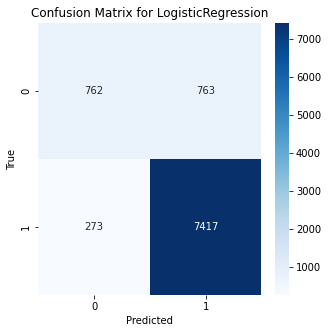

Model: KNeighborsClassifier
Best Parameters: {'classifier__n_neighbors': 12, 'classifier__metric': 'euclidean'}
Classification Report:               precision    recall  f1-score   support

           0       0.70      0.41      0.52      1525
           1       0.89      0.97      0.93      7690

    accuracy                           0.87      9215
   macro avg       0.80      0.69      0.72      9215
weighted avg       0.86      0.87      0.86      9215



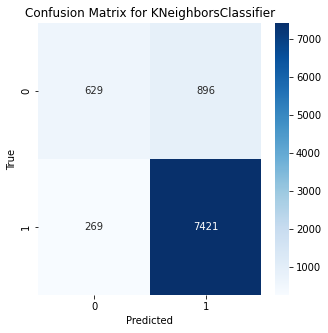

Model: RandomForestClassifier
Best Parameters: {'classifier__n_estimators': 200, 'classifier__max_depth': None}
Classification Report:               precision    recall  f1-score   support

           0       0.79      0.34      0.48      1525
           1       0.88      0.98      0.93      7690

    accuracy                           0.88      9215
   macro avg       0.84      0.66      0.70      9215
weighted avg       0.87      0.88      0.86      9215



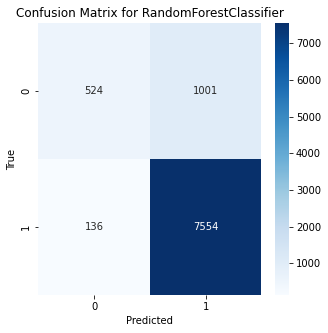

Model: GradientBoostingClassifier
Best Parameters: {'classifier__n_estimators': 200, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1}
Classification Report:               precision    recall  f1-score   support

           0       0.74      0.51      0.60      1525
           1       0.91      0.96      0.94      7690

    accuracy                           0.89      9215
   macro avg       0.82      0.74      0.77      9215
weighted avg       0.88      0.89      0.88      9215



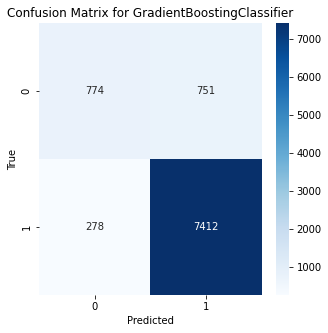

Model: SVC
Best Parameters: {'classifier__kernel': 'rbf', 'classifier__gamma': 0.01, 'classifier__C': 10}
Classification Report:               precision    recall  f1-score   support

           0       0.72      0.58      0.64      1525
           1       0.92      0.96      0.94      7690

    accuracy                           0.89      9215
   macro avg       0.82      0.77      0.79      9215
weighted avg       0.89      0.89      0.89      9215



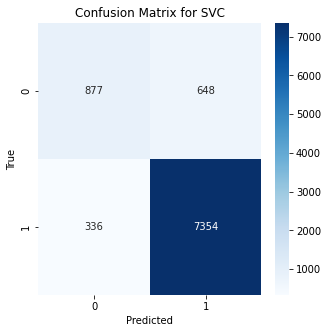

In [20]:
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC()
}

#hyperparameters
hyperparameters = {
    'LogisticRegression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
    },
    'KNeighborsClassifier': {
        'classifier__n_neighbors': list(range(1, 31)),
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 30, 15, 5],
    },
    'GradientBoostingClassifier': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 1],
        'classifier__max_depth': [3, 5, 7]
    },
    'SVC': {
        'classifier__C': [0.1, 1, 10, 100], 
        'classifier__gamma': [1, 0.1, 0.01, 0.001],
        'classifier__kernel': ['rbf', 'poly', 'sigmoid']
    }
}

best_score = 0
best_model_name = ''

for model in models.keys():
    pipeline = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', models[model])
    ])
    
    #  Randomized search 
    clf = RandomizedSearchCV(pipeline, hyperparameters[model], n_iter=10, cv=5, random_state=0)
    clf.fit(x_train, y_train)
    
    # Keep track of the model with the best score
    if clf.best_score_ > best_score:
        best_score = clf.best_score_
        best_model_name = model
        best_params[best_model_name] = clf.best_params_
    
    y_pred = clf.predict(x_test)
    
    print(f'Model: {model}')
    print('Best Parameters:', clf.best_params_)
    print('Classification Report:', classification_report(y_test, y_pred))
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()  
    
    # Break the loop if the accuracy is above a certain threshold
    if best_score > 0.95:
        print(f'Stopping search: {best_model_name} reached accuracy > 95%')
        break

# Save The Model in Pickle File

In [ ]:
# save the final model into a pickle file
final_model_rf = RandomForestClassifier(n_estimators=200, max_depth=None)
final_model_rf.fit(x_train, y_train)

with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model_rf, f)


# Copy Write By Mostafa Themar